<a href="https://colab.research.google.com/github/DS-1090/Traduire/blob/main/English_French_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install wordcloud

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences, to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

Data Processing

In [4]:
df = pd.read_csv("eng-french.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df[:50000]

df.sample(2)

,English,French
1821,That baby is fat and healthy.,Ce bébé est dodu et en bonne santé.
11923,How much does she spend per month?,Combien dépense-t-elle par mois?


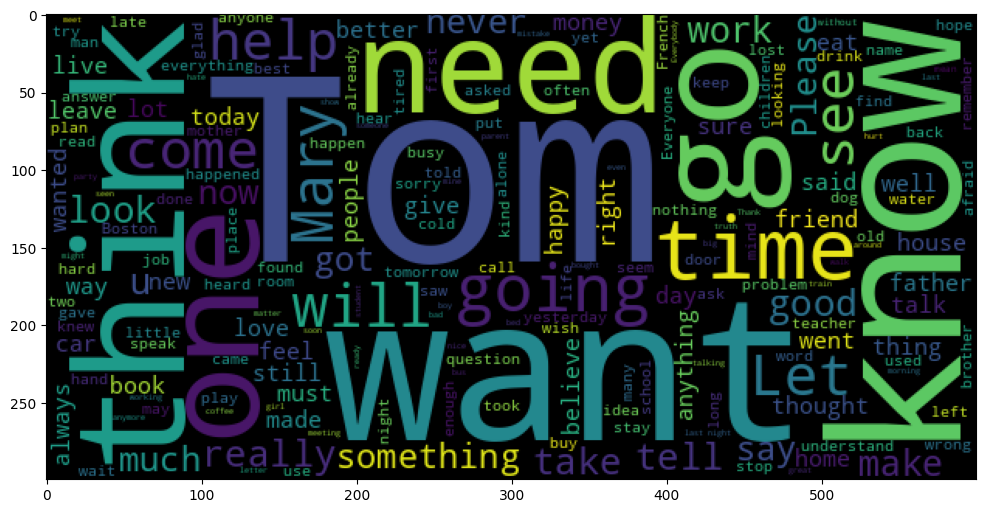

In [5]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(df['English']))
plt.imshow(wc)
plt.show();

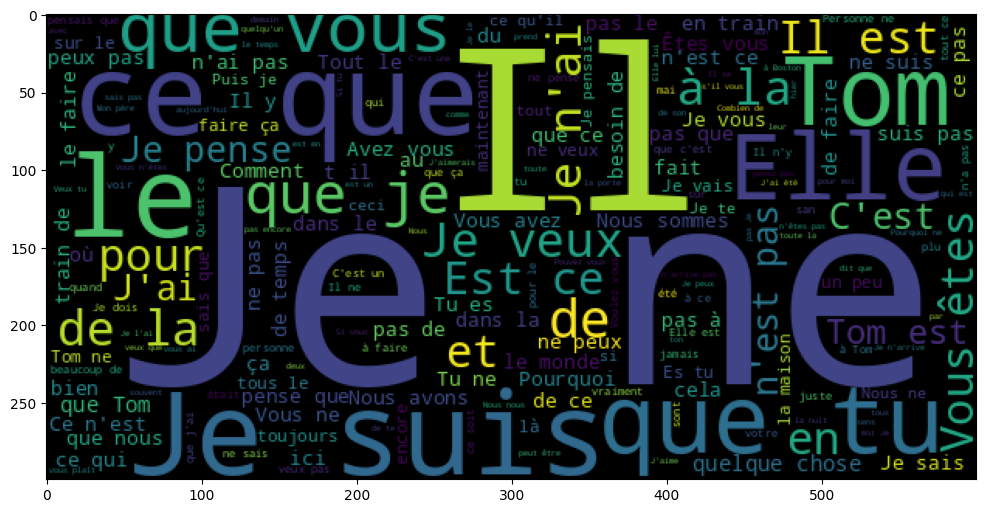

In [6]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(df['French']))
plt.imshow(wc)
plt.show();

In [7]:
df.describe()

,English,French
count,50000,50000
unique,44067,49097
top,You don't have to apologize.,C'est bizarre.
freq,10,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  50000 non-null  object
 1   French   50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
df = df.apply(lambda x: x.str.lower())
df = df.dropna()

In [10]:
df.shape

(50000, 2)

In [11]:
df.sample(4)

,English,French
3867,this vase is fragile.,ce vase est fragile.
28487,i've read your book. it was very interesting.,j'ai lu ton livre. il était très intéressant.
34892,shall i help you?,dois-je t'aider ?
30119,can rabbits swim?,les lapins savent-ils nager ?


Data Tokenization & Encoding


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(phrase):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(phrase)
  return tokenizer

def maxlength(phrase):
  return max(len(p.split()) for p in phrase)

def encode(tokenizer,phrase,maxlen):
  texttoseq = tokenizer.texts_to_sequences(phrase)
  textpadseq = pad_sequences(texttoseq,maxlen=maxlen,padding='post')
  return textpadseq


In [13]:
eng_tokenizer = tokenize(df['English'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_len = maxlength(df['English'])
print("English vocabulary size:", eng_vocab_size)
print("Maximum length of English phrase:", max_eng_len)

English vocabulary size: 9427
Maximum length of English phrase: 35


In [14]:
fr_tokenizer = tokenize(df['French'])
fr_vocab_size = len(fr_tokenizer.word_index) + 1
max_fr_len = maxlength(df['French'])
print("French vocabulary size:", fr_vocab_size)
print("Maximum length of French phrase:", max_fr_len)

French vocabulary size: 17680
Maximum length of French phrase: 40


In [15]:
X = encode(eng_tokenizer,df['English'],20)
y = encode(fr_tokenizer,df['French'],20)

In [16]:
max_fr_len = 20
max_eng_len = 20


In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.1,shuffle=True,random_state=42)


In [18]:
Xtrain

array([[   1,   16,   40, ...,    0,    0,    0],
       [  12, 5028,   15, ...,    0,    0,    0],
       [   1,   92,  775, ...,    0,    0,    0],
       ...,
       [   1, 2137,   81, ...,    0,    0,    0],
       [ 104,   67,    3, ...,    0,    0,    0],
       [  14,   19,  886, ...,    0,    0,    0]], dtype=int32)

In [19]:
Xtrain.shape

(45000, 20)

Data Training

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def create_model(src_vocab_size, dest_vocab_size, src_timesteps, dest_timesteps, num_neurons):
    model = Sequential()

    model.add(Embedding(src_vocab_size, num_neurons, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(num_neurons, return_sequences=False))

    model.add(RepeatVector(dest_timesteps))

    model.add(LSTM(num_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(dest_vocab_size, activation='softmax')))
    model.build(input_shape=(None, src_timesteps))

    return model
model = create_model(eng_vocab_size, fr_vocab_size, max_eng_len, max_fr_len, 512)

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 512)             │       4,826,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 20, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 512)             │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 1024)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 17680)           │      18,122,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,672,336 (105.56 MB)

 Trainable params: 27,672,336 (105.56 MB)

 Non-trainable params: 0 (0.00 B)

Model Train

In [21]:
es = EarlyStopping(monitor='val_accuracy',patience=3,mode='max',verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,mode='max',verbose=1,factor=0.1,min_lr=0.001)


In [22]:
print(np.max(ytrain))

17679


In [ ]:
hist = model.fit(Xtrain,
              ytrain.reshape(ytrain.shape[0],ytrain.shape[1],1),
              epochs=5,
              batch_size=512,
              callbacks=[es,lr],
              validation_split=0.1
)

Epoch 1/5
80/80 [==============================] - 1890s 24s/step - loss: 3.4378 - accuracy: 0.6585 - val_loss: 2.5991 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 2/5
80/80 [==============================] - 1883s 24s/step - loss: 2.4756 - accuracy: 0.6771 - val_loss: 2.3518 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 3/5
80/80 [==============================] - 1880s 24s/step - loss: 2.3641 - accuracy: 0.6817 - val_loss: 2.3041 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 4/5
80/80 [==============================] - 1876s 23s/step - loss: 2.3148 - accuracy: 0.6834 - val_loss: 2.3255 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 5/5
80/80 [==============================] - 1878s 23s/step - loss: 2.2814 - accuracy: 0.6847 - val_loss: 2.2785 - val_accuracy: 0.6846 - lr: 0.0010


In [ ]:
pip install pydot

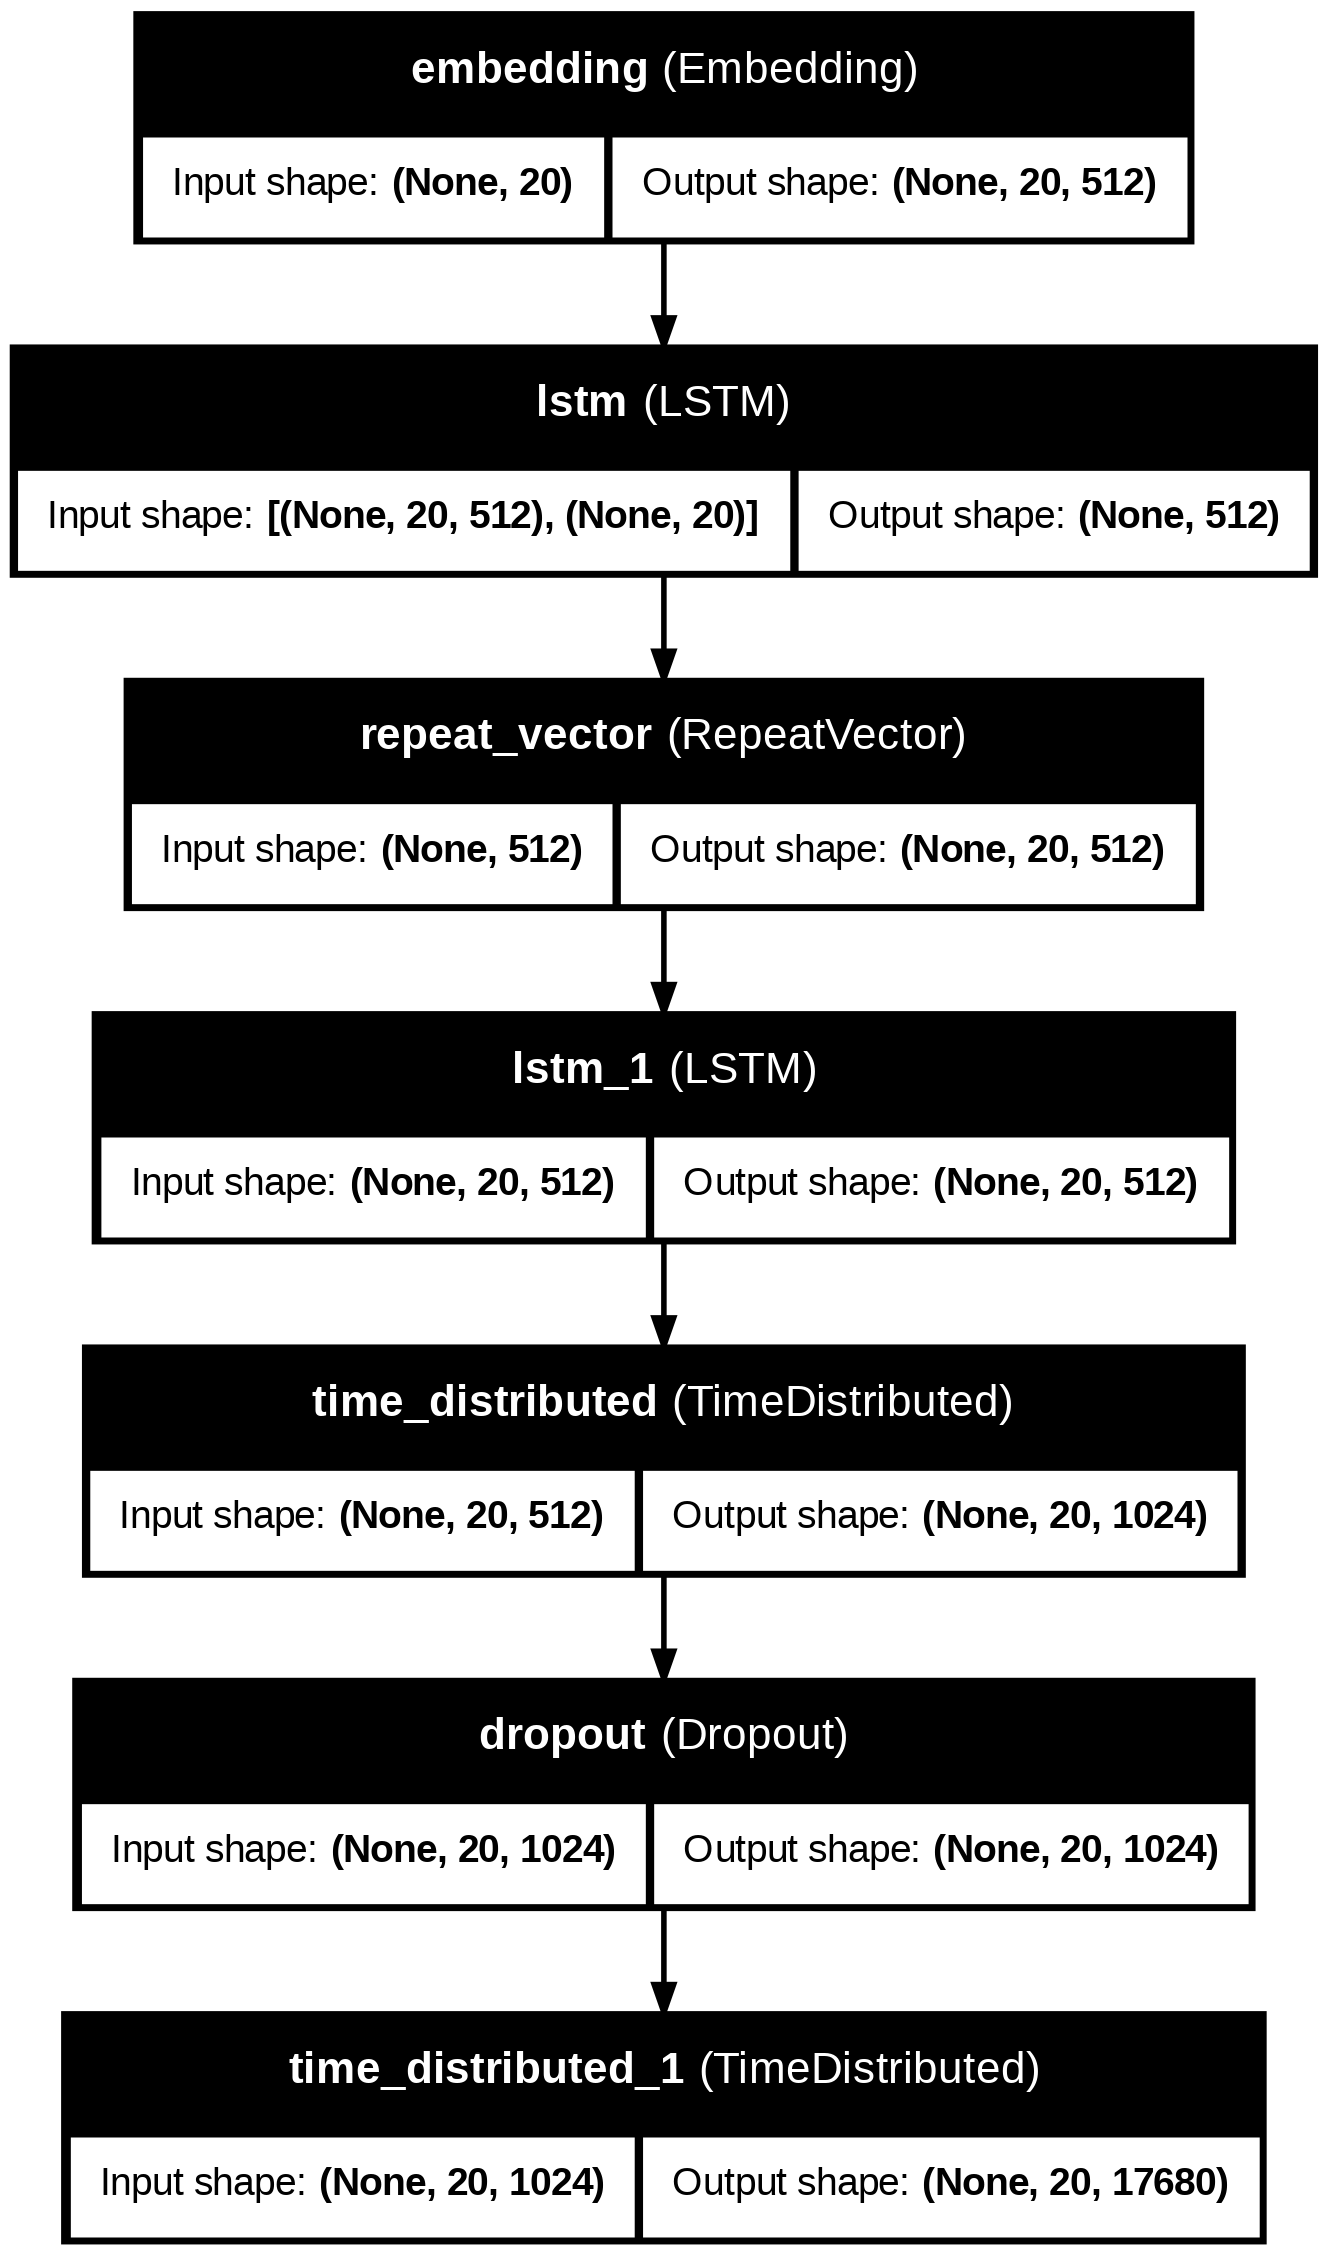

In [23]:
from keras.utils import plot_model

plot_model(model, to_file='model_trn_plot.png', show_shapes=True, show_layer_names=True)


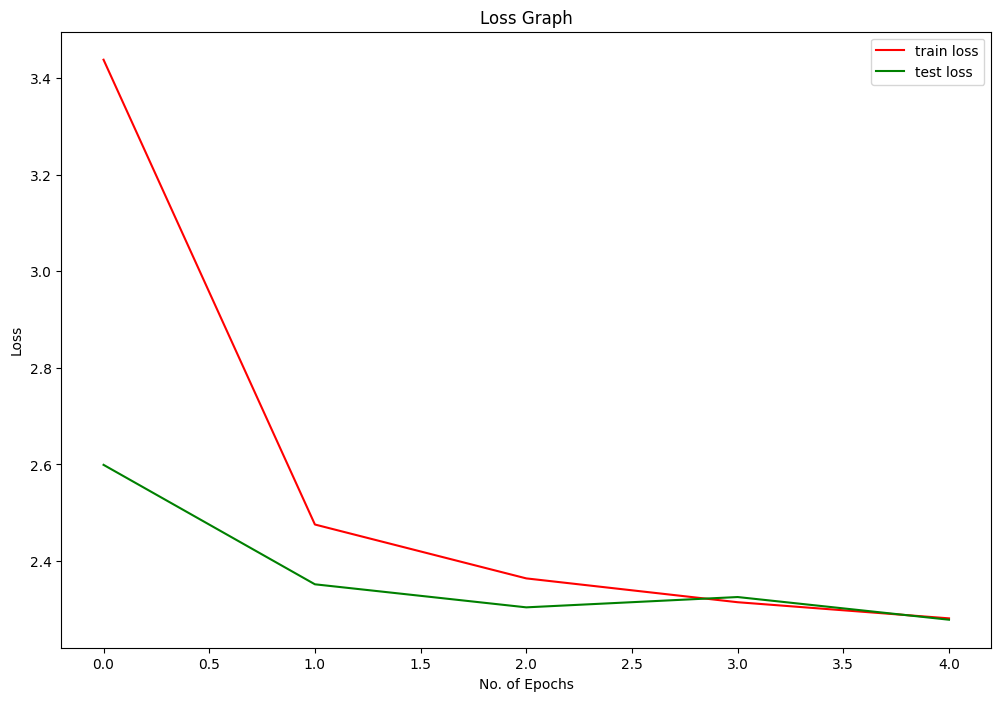

In [ ]:

plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'],'r',label='train loss')
plt.plot(hist.history['val_loss'],'g',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

In [ ]:
model.evaluate(Xtest,ytest.reshape(ytest.shape[0],ytest.shape[1],1))


157/157 [==============================] - 94s 597ms/step - loss: 2.2819 - accuracy: 0.6848


[2.281947374343872, 0.6847900152206421]

In [ ]:
import pickle

pickle.dump(model, open('model_trn.sav', 'wb'))

In [ ]:
model.save('english_to_french_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Prediction


In [ ]:
sample_test, orig_fra_sent = Xtest[200:210], ytest[200:210]
sample_test[:2], orig_fra_sent[:2]

(array([[  2,  89, 144,  10,  23, 251,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0],
        [ 24, 667,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0]], dtype=int32),
 array([[  86,  506,  108,   26,    2,   52,  163,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   23, 1033,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0]],
       dtype=int32))

In [ ]:
test_predictions = model.predict(sample_test)
test_predictions[:2]

1/1 [==============================] - 0s 198ms/step


array([[[2.2662405e-05, 4.0245062e-01, 7.9617428e-04, ...,
         3.7862438e-07, 3.9200503e-07, 3.5536939e-07],
        [1.6282847e-04, 1.5515865e-02, 9.5750317e-03, ...,
         2.3109994e-06, 2.3896237e-06, 2.2064478e-06],
        [7.8407989e-04, 9.8225530e-03, 3.2999683e-02, ...,
         3.5712885e-06, 3.7622174e-06, 3.2557634e-06],
        ...,
        [9.9850500e-01, 2.2783242e-05, 1.4902516e-04, ...,
         3.1822817e-10, 5.1843929e-10, 5.4377580e-10],
        [9.9857795e-01, 2.2086710e-05, 1.4209798e-04, ...,
         2.9201327e-10, 4.7673154e-10, 5.0033039e-10],
        [9.9862880e-01, 2.1625281e-05, 1.3716094e-04, ...,
         2.7433766e-10, 4.4849638e-10, 4.7087984e-10]],

       [[6.9991854e-04, 9.4534434e-02, 2.6050303e-03, ...,
         9.4086699e-06, 9.9806930e-06, 9.4206471e-06],
        [6.5106745e-03, 2.0056682e-02, 1.1706447e-02, ...,
         5.3182303e-06, 5.9078229e-06, 5.6671788e-06],
        [7.3315710e-02, 6.0741999e-03, 2.5576485e-02, ...,
         6.689

In [ ]:
def convert_pred_to_sent(input_seq):
    sent = ''
    for idx in input_seq:
      if idx:
        sent += fr_tokenizer.index_word[idx] + ' '
    sent = sent[:-1]
    return sent

In [ ]:
def convert_idx_to_sent(input_seq,tokenizer):
    sent = ''
    for idx in input_seq:
      if idx:
        sent += tokenizer.index_word[idx] + ' '
    return sent

In [ ]:
orig_eng_text = []
orig_fra_text = []
pred_fra_text = []

for i in range(len(sample_test)):
  orig_eng_text.append(convert_idx_to_sent(sample_test[i],eng_tokenizer))
  pred_fra_text.append(convert_pred_to_sent(np.argmax(test_predictions[i],axis=1)))
  orig_fra_text.append(convert_idx_to_sent(orig_fra_sent[i],fr_tokenizer))

In [ ]:
predictions = pd.DataFrame()
predictions['Original English '] = orig_eng_text
predictions['Original French '] = orig_fra_text
predictions['Predicted French '] = pred_fra_text
predictions

,Original English,Original French,Predicted French
0,you should always do your best,on devrait toujours faire de son mieux,je ne pas pas de
1,i'm serious,je suis sérieux,je est
2,they attributed his bad manners to lack of tra...,ils ont mis ses mauvaises manières sur le comp...,je est de de de de de de de
3,changes came quickly,les changements survinrent rapidement,je est
4,try to remain calm,essayez de rester calme,je est
5,please keep this a secret,veuillez le tenir secret,je ne pas de
6,the moon is bright,la lune est éclatante,je est est
7,it's green,c'est vert,je est
8,i want to return your money,je veux vous rendre votre argent,je ne pas pas pas
9,tom sometimes comes to see me,tom vient parfois me voir,je ne pas pas de


In [ ]:
input_sentence = "I don't go"

input_sequence = eng_tokenizer.texts_to_sequences([input_sentence])
input_sequence = pad_sequences(input_sequence, maxlen=20, padding='post')

output_sequence = model.predict(input_sequence)

output_tokens = tf.argmax(output_sequence, axis=-1).numpy()[0]

decoded_sentence = " ".join([fr_tokenizer.index_word[token] for token in output_tokens if token != 0])

print("Translation:", decoded_sentence)

1/1 [==============================] - 0s 74ms/step
Translation: je ne pas


In [24]:
index_to_word = {index: word for word, index in eng_tokenizer.word_index.items()}
sorted_words = sorted(eng_tokenizer.word_index.items(), key=lambda x: x[1])
top_10_words = sorted_words[:10]
print("Top 10 Most Frequent Words:")
for word, index in top_10_words:
    print(f"{word}")

Top 10 Most Frequent Words:
i
you
to
the
a
is
tom
that
he
do
